<a href="https://colab.research.google.com/github/prp20/tensorflow_learning/blob/main/practice_timeseries_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd

/bin/bash: /home/prp/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/prp/tensorflow_learning/practice_notebooks


In [2]:
!unzip /content/archive.zip -d /content/dataset

/bin/bash: /home/prp/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
unzip:  cannot find or open /content/archive.zip, /content/archive.zip.zip or /content/archive.zip.ZIP.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

2023-03-04 12:30:39.567376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 12:30:40.303710: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/prp/anaconda3/lib/
2023-03-04 12:30:40.303815: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/prp/anaconda3/lib/
2023-03-04 12:30:40.303824: W tensorflow/compiler/tf2tensorrt/utils/py_utils.c

In [4]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2023-03-04 12:30:41.511828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-04 12:30:41.517744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-04 12:30:41.517807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
def load_data(path, col=None, verbose=False):
    df = pd.read_csv(path)
    if col is not None:
        df = df[col]
    if verbose:
        print(df.head())
    return df

train_data_path = "/mnt/d/Learning/tensorflow_learning/datasets/DailyDelhiClimateTrain.csv"
test_data_path = "/mnt/d/Learning/tensorflow_learning/datasets/DailyDelhiClimateTest.csv"
train_df = load_data(train_data_path, verbose=True)
test_df = load_data(test_data_path)

         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000


In [6]:
def clean_data(series):
    """Fills missing values. 
    
        Interpolate missing values with a linear approximation.
    """
    series_filled = series.interpolate(method='linear')
        
    return series_filled
        
    
def min_max_scale(dataframe):
    """ Applies MinMax Scaling
    
        Wrapper for sklearn's MinMaxScaler class.
    """
    mm = MinMaxScaler()
    return mm.fit_transform(dataframe)

def make_time_features(series):
    
    #convert series to datetimes
    datetimes = pd.DatetimeIndex(series)
    
    year = datetimes.year.values
    day = datetimes.day.values
    months = datetimes.month.values
    
    years = pd.Series(year, name='hours')
    dayofw = pd.Series(day, name='dayofw')
    month = pd.Series(months, name='months')
    
    return years, dayofw, month

In [7]:
def split_data(series, train_fraq):
    """Splits input series into train, val and test.
    
        Default to 1 year of test data.
    """
    #slice the last year of data for testing 1 year has 8760 hours
    train_val_data = series

    #make train and validation from the remaining
    train_size = int(len(train_val_data) * train_fraq)
    
    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]
    test_data = val_data
    return train_data, val_data, test_data

In [8]:
def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):
    window = n_steps + n_horizon
    if expand_dims:
        ds = tf.expand_dims(data, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(ds)
    else:
        ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    ds = ds.flat_map(lambda x : x.batch(window))
    ds = ds.shuffle(shuffle_buffer)    
    if multi_var:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:, :1]))
    else:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [29]:
def build_dataset(n_steps, n_horizon, batch_size=128, shuffle_buffer=100, expand_dims=False, multi_var=False):
    tf.random.set_seed(23)
    
    if multi_var:
        data = load_data(train_data_path, col=['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'])
        years, day, months = make_time_features(data.date)
        data = pd.concat([data.drop(['date'], axis=1), years, day, months], axis=1)
    else:
        data = load_data(col=['meantemp'])
        
    data = clean_data(data)
    
    if multi_var:
        mm = MinMaxScaler()
        data = mm.fit_transform(data)
    
    train_data, val_data, test_data = split_data(data, train_fraq=0.8)
    
    train_ds = window_dataset(train_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    val_ds = window_dataset(val_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    test_ds = window_dataset(test_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    
    return train_ds, val_ds, test_ds

In [30]:
def get_params(multivar=False):
    lr = 3e-4
    n_steps=10
    n_horizon=1
    if multivar:
        n_features=7
    else:
        n_features=1
        
    return n_steps, n_horizon, n_features, lr

In [31]:
model_configs = dict()

def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}

def get_callbacks(model_name):
  callbacks = []
  MC = tf.keras.callbacks.ModelCheckpoint(f'saved_models/ts_practice_2/{model_name}', monitor='val_loss', save_best_only='True', verbose=1)
  ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights='True')
  return [MC, ES]

def run_model(model_name, model_func, model_configs, epochs):
    
    n_steps, n_horizon, n_features, lr = get_params(multivar=True)
    train_ds, val_ds, test_ds = build_dataset(n_steps=n_steps, n_horizon=n_horizon, multi_var=True)

    model = model_func(n_steps, n_horizon, n_features, lr=lr)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks= get_callbacks(model.name))

    model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
    return test_ds

In [32]:
def dnn_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(n_steps, n_features)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='dnn')
    
    loss=tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model


dnn = dnn_model(*get_params(multivar=True))
dnn.summary()

Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 70)                0         
                                                                 
 dense (Dense)               (None, 128)               9088      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 25,729
Trainable params: 25,729
Non-trainable par

In [33]:
def cnn_model(n_steps, n_horizon, n_features, lr=3e-4):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="CNN")
    
    loss= tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

cnn = cnn_model(*get_params(multivar=True))
cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 64)             1408      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0       

In [34]:
def lstm_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='lstm')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm = lstm_model(*get_params(multivar=True))
lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 72)            23040     
                                                                 
 lstm_1 (LSTM)               (None, 48)                23232     
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 128)               6272      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129    

In [35]:
def lstm_cnn_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.LSTM(72, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="lstm_cnn")
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_cnn = lstm_cnn_model(*get_params(multivar=True))
lstm_cnn.summary()

Model: "lstm_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 64)             1408      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 1, 72)             39456     
                                                                 
 lstm_1 (LSTM)               (None, 48)                232

In [36]:
def lstm_cnn_skip_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
   
    inputs = tf.keras.layers.Input(shape=(n_steps,n_features), name='main')
    
    conv1 = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling1D(2)(conv1)
    conv2 = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling1D(2)(conv2)
    lstm_1 = tf.keras.layers.LSTM(72, activation='relu', return_sequences=True)(max_pool_2)
    lstm_2 = tf.keras.layers.LSTM(48, activation='relu', return_sequences=False)(lstm_1)
    flatten = tf.keras.layers.Flatten()(lstm_2)
    
    skip_flatten = tf.keras.layers.Flatten()(inputs)

    concat = tf.keras.layers.Concatenate(axis=-1)([flatten, skip_flatten])
    drop_1 = tf.keras.layers.Dropout(0.3)(concat)
    dense_1 = tf.keras.layers.Dense(128, activation='relu')(drop_1)
    drop_2 = tf.keras.layers.Dropout(0.3)(dense_1)
    output = tf.keras.layers.Dense(n_horizon)(drop_2)
    
    model = tf.keras.Model(inputs=inputs, outputs=output, name='lstm_skip')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_skip = lstm_cnn_skip_model(*get_params(multivar=True))
lstm_skip.summary()

Model: "lstm_skip"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main (InputLayer)              [(None, 10, 7)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 8, 64)        1408        ['main[0][0]']                   
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 4, 64)        0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 2, 64)        12352       ['max_pooling1d[0][0]']          
                                                                                          

In [37]:
model_configs=dict()
run_model("dnn", dnn_model, model_configs, epochs=150)
run_model("cnn", cnn_model, model_configs, epochs=150)
run_model("lstm", lstm_model, model_configs, epochs=150)
run_model("lstm_cnn", lstm_cnn_model, model_configs, epochs=150)
run_model("lstm_skip", lstm_cnn_skip_model, model_configs, epochs=150)

Epoch 1/150
      6/Unknown - 1s 11ms/step - loss: 0.0819 - mae: 0.3199
Epoch 1: val_loss improved from inf to 0.03408, saving model to saved_models/ts_practice_2/dnn
INFO:tensorflow:Assets written to: saved_models/ts_practice_2/dnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/dnn/assets


10/10 [==============================] - 2s 88ms/step - loss: 0.0689 - mae: 0.2927 - val_loss: 0.0341 - val_mae: 0.2417
Epoch 2/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0382 - mae: 0.2240
Epoch 2: val_loss improved from 0.03408 to 0.00893, saving model to saved_models/ts_practice_2/dnn
INFO:tensorflow:Assets written to: saved_models/ts_practice_2/dnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/dnn/assets


10/10 [==============================] - 1s 77ms/step - loss: 0.0382 - mae: 0.2241 - val_loss: 0.0089 - val_mae: 0.1125
Epoch 3/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0275 - mae: 0.1836
Epoch 3: val_loss did not improve from 0.00893
10/10 [==============================] - 0s 21ms/step - loss: 0.0274 - mae: 0.1835 - val_loss: 0.0111 - val_mae: 0.1303
Epoch 4/150
 8/10 [=======================>......] - ETA: 0s - loss: 0.0193 - mae: 0.1575
Epoch 4: val_loss improved from 0.00893 to 0.00399, saving model to saved_models/ts_practice_2/dnn
INFO:tensorflow:Assets written to: saved_models/ts_practice_2/dnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/dnn/assets


10/10 [==============================] - 1s 75ms/step - loss: 0.0190 - mae: 0.1565 - val_loss: 0.0040 - val_mae: 0.0713
Epoch 5/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0157 - mae: 0.1411
Epoch 5: val_loss did not improve from 0.00399
10/10 [==============================] - 0s 21ms/step - loss: 0.0157 - mae: 0.1407 - val_loss: 0.0052 - val_mae: 0.0805
Epoch 6/150
 8/10 [=======================>......] - ETA: 0s - loss: 0.0156 - mae: 0.1408
Epoch 6: val_loss improved from 0.00399 to 0.00394, saving model to saved_models/ts_practice_2/dnn
INFO:tensorflow:Assets written to: saved_models/ts_practice_2/dnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/dnn/assets


10/10 [==============================] - 1s 77ms/step - loss: 0.0154 - mae: 0.1400 - val_loss: 0.0039 - val_mae: 0.0692
Epoch 7/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0137 - mae: 0.1289
Epoch 7: val_loss did not improve from 0.00394
10/10 [==============================] - 0s 23ms/step - loss: 0.0133 - mae: 0.1283 - val_loss: 0.0047 - val_mae: 0.0764
Epoch 8/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0130 - mae: 0.1281
Epoch 8: val_loss improved from 0.00394 to 0.00383, saving model to saved_models/ts_practice_2/dnn
INFO:tensorflow:Assets written to: saved_models/ts_practice_2/dnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/dnn/assets


10/10 [==============================] - 1s 76ms/step - loss: 0.0130 - mae: 0.1279 - val_loss: 0.0038 - val_mae: 0.0683
Epoch 9/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0126 - mae: 0.1260
Epoch 9: val_loss did not improve from 0.00383
10/10 [==============================] - 0s 22ms/step - loss: 0.0120 - mae: 0.1226 - val_loss: 0.0057 - val_mae: 0.0855
Epoch 10/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0112 - mae: 0.1174
Epoch 10: val_loss did not improve from 0.00383
10/10 [==============================] - 0s 23ms/step - loss: 0.0112 - mae: 0.1176 - val_loss: 0.0041 - val_mae: 0.0716
Epoch 11/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0100 - mae: 0.1124
Epoch 11: val_loss did not improve from 0.00383
10/10 [==============================] - 0s 21ms/step - loss: 0.0099 - mae: 0.1121 - val_loss: 0.0045 - val_mae: 0.0757
Epoch 12/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0112 - mae: 0.1180
Epoch 12: val_

Epoch 1/150
      7/Unknown - 1s 11ms/step - loss: 0.0507 - mae: 0.2524
Epoch 1: val_loss improved from inf to 0.01036, saving model to saved_models/ts_practice_2/CNN


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/CNN/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/CNN/assets


10/10 [==============================] - 2s 114ms/step - loss: 0.0454 - mae: 0.2369 - val_loss: 0.0104 - val_mae: 0.1193
Epoch 2/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0187 - mae: 0.1519
Epoch 2: val_loss improved from 0.01036 to 0.00403, saving model to saved_models/ts_practice_2/CNN


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/CNN/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/CNN/assets


10/10 [==============================] - 1s 117ms/step - loss: 0.0173 - mae: 0.1462 - val_loss: 0.0040 - val_mae: 0.0728
Epoch 3/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0123 - mae: 0.1248
Epoch 3: val_loss improved from 0.00403 to 0.00342, saving model to saved_models/ts_practice_2/CNN


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/CNN/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/CNN/assets


10/10 [==============================] - 1s 94ms/step - loss: 0.0123 - mae: 0.1247 - val_loss: 0.0034 - val_mae: 0.0651
Epoch 4/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0112 - mae: 0.1172
Epoch 4: val_loss improved from 0.00342 to 0.00322, saving model to saved_models/ts_practice_2/CNN


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/CNN/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/CNN/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0112 - mae: 0.1170 - val_loss: 0.0032 - val_mae: 0.0637
Epoch 5/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0102 - mae: 0.1132
Epoch 5: val_loss did not improve from 0.00322
10/10 [==============================] - 0s 22ms/step - loss: 0.0101 - mae: 0.1120 - val_loss: 0.0047 - val_mae: 0.0811
Epoch 6/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0093 - mae: 0.1076
Epoch 6: val_loss did not improve from 0.00322
10/10 [==============================] - 0s 21ms/step - loss: 0.0093 - mae: 0.1074 - val_loss: 0.0050 - val_mae: 0.0840
Epoch 7/150
 8/10 [=======================>......] - ETA: 0s - loss: 0.0084 - mae: 0.1019
Epoch 7: val_loss improved from 0.00322 to 0.00266, saving model to saved_models/ts_practice_2/CNN


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/CNN/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/CNN/assets


10/10 [==============================] - 1s 98ms/step - loss: 0.0082 - mae: 0.1014 - val_loss: 0.0027 - val_mae: 0.0592
Epoch 8/150
 8/10 [=======================>......] - ETA: 0s - loss: 0.0085 - mae: 0.1015
Epoch 8: val_loss did not improve from 0.00266
10/10 [==============================] - 0s 23ms/step - loss: 0.0082 - mae: 0.1002 - val_loss: 0.0029 - val_mae: 0.0587
Epoch 9/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0073 - mae: 0.0958
Epoch 9: val_loss improved from 0.00266 to 0.00215, saving model to saved_models/ts_practice_2/CNN


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/CNN/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/CNN/assets


10/10 [==============================] - 1s 96ms/step - loss: 0.0073 - mae: 0.0957 - val_loss: 0.0022 - val_mae: 0.0508
Epoch 10/150
 8/10 [=======================>......] - ETA: 0s - loss: 0.0063 - mae: 0.0872
Epoch 10: val_loss did not improve from 0.00215
10/10 [==============================] - 0s 22ms/step - loss: 0.0061 - mae: 0.0859 - val_loss: 0.0035 - val_mae: 0.0688
Epoch 11/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0064 - mae: 0.0883
Epoch 11: val_loss did not improve from 0.00215
10/10 [==============================] - 0s 24ms/step - loss: 0.0061 - mae: 0.0858 - val_loss: 0.0045 - val_mae: 0.0801
Epoch 12/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0054 - mae: 0.0808
Epoch 12: val_loss did not improve from 0.00215
10/10 [==============================] - 0s 22ms/step - loss: 0.0054 - mae: 0.0808 - val_loss: 0.0025 - val_mae: 0.0566
Epoch 13/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0056 - mae: 0.0825
Epoch 13: va

Epoch 1/150
     10/Unknown - 3s 79ms/step - loss: 0.1309 - mae: 0.4549
Epoch 1: val_loss improved from inf to 0.05463, saving model to saved_models/ts_practice_2/lstm
INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm/assets


10/10 [==============================] - 5s 346ms/step - loss: 0.1309 - mae: 0.4549 - val_loss: 0.0546 - val_mae: 0.2985
Epoch 2/150
10/10 [==============================] - ETA: 0s - loss: 0.0441 - mae: 0.2399
Epoch 2: val_loss improved from 0.05463 to 0.01567, saving model to saved_models/ts_practice_2/lstm
INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm/assets


10/10 [==============================] - 3s 332ms/step - loss: 0.0441 - mae: 0.2399 - val_loss: 0.0157 - val_mae: 0.1483
Epoch 3/150
10/10 [==============================] - ETA: 0s - loss: 0.0276 - mae: 0.1976
Epoch 3: val_loss did not improve from 0.01567
10/10 [==============================] - 1s 90ms/step - loss: 0.0276 - mae: 0.1976 - val_loss: 0.0285 - val_mae: 0.2135
Epoch 4/150
10/10 [==============================] - ETA: 0s - loss: 0.0230 - mae: 0.1785
Epoch 4: val_loss improved from 0.01567 to 0.00935, saving model to saved_models/ts_practice_2/lstm
INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm/assets


10/10 [==============================] - 3s 302ms/step - loss: 0.0230 - mae: 0.1785 - val_loss: 0.0094 - val_mae: 0.1070
Epoch 5/150
10/10 [==============================] - ETA: 0s - loss: 0.0159 - mae: 0.1448
Epoch 5: val_loss did not improve from 0.00935
10/10 [==============================] - 1s 77ms/step - loss: 0.0159 - mae: 0.1448 - val_loss: 0.0102 - val_mae: 0.1238
Epoch 6/150
10/10 [==============================] - ETA: 0s - loss: 0.0134 - mae: 0.1327
Epoch 6: val_loss improved from 0.00935 to 0.00499, saving model to saved_models/ts_practice_2/lstm
INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm/assets


10/10 [==============================] - 3s 333ms/step - loss: 0.0134 - mae: 0.1327 - val_loss: 0.0050 - val_mae: 0.0810
Epoch 7/150
10/10 [==============================] - ETA: 0s - loss: 0.0097 - mae: 0.1097
Epoch 7: val_loss improved from 0.00499 to 0.00413, saving model to saved_models/ts_practice_2/lstm
INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm/assets


10/10 [==============================] - 3s 304ms/step - loss: 0.0097 - mae: 0.1097 - val_loss: 0.0041 - val_mae: 0.0719
Epoch 8/150
10/10 [==============================] - ETA: 0s - loss: 0.0085 - mae: 0.1018
Epoch 8: val_loss did not improve from 0.00413
10/10 [==============================] - 1s 88ms/step - loss: 0.0085 - mae: 0.1018 - val_loss: 0.0043 - val_mae: 0.0713
Epoch 9/150
10/10 [==============================] - ETA: 0s - loss: 0.0074 - mae: 0.0950
Epoch 9: val_loss did not improve from 0.00413
10/10 [==============================] - 1s 81ms/step - loss: 0.0074 - mae: 0.0950 - val_loss: 0.0069 - val_mae: 0.0944
Epoch 10/150
10/10 [==============================] - ETA: 0s - loss: 0.0078 - mae: 0.0973
Epoch 10: val_loss improved from 0.00413 to 0.00287, saving model to saved_models/ts_practice_2/lstm
INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm/assets


10/10 [==============================] - 3s 333ms/step - loss: 0.0078 - mae: 0.0973 - val_loss: 0.0029 - val_mae: 0.0594
Epoch 11/150
10/10 [==============================] - ETA: 0s - loss: 0.0066 - mae: 0.0889
Epoch 11: val_loss improved from 0.00287 to 0.00251, saving model to saved_models/ts_practice_2/lstm
INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm/assets


10/10 [==============================] - 3s 312ms/step - loss: 0.0066 - mae: 0.0889 - val_loss: 0.0025 - val_mae: 0.0562
Epoch 12/150
10/10 [==============================] - ETA: 0s - loss: 0.0072 - mae: 0.0936
Epoch 12: val_loss did not improve from 0.00251
10/10 [==============================] - 1s 84ms/step - loss: 0.0072 - mae: 0.0936 - val_loss: 0.0047 - val_mae: 0.0782
Epoch 13/150
10/10 [==============================] - ETA: 0s - loss: 0.0066 - mae: 0.0885
Epoch 13: val_loss did not improve from 0.00251
10/10 [==============================] - 1s 85ms/step - loss: 0.0066 - mae: 0.0885 - val_loss: 0.0054 - val_mae: 0.0841
Epoch 14/150
10/10 [==============================] - ETA: 0s - loss: 0.0069 - mae: 0.0922
Epoch 14: val_loss did not improve from 0.00251
10/10 [==============================] - 1s 81ms/step - loss: 0.0069 - mae: 0.0922 - val_loss: 0.0027 - val_mae: 0.0595
Epoch 15/150
10/10 [==============================] - ETA: 0s - loss: 0.0066 - mae: 0.0902
Epoch 15: v

Epoch 1/150
     10/Unknown - 3s 20ms/step - loss: 0.1500 - mae: 0.4958
Epoch 1: val_loss improved from inf to 0.14087, saving model to saved_models/ts_practice_2/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_cnn/assets


10/10 [==============================] - 6s 349ms/step - loss: 0.1500 - mae: 0.4958 - val_loss: 0.1409 - val_mae: 0.5013
Epoch 2/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0656 - mae: 0.3073
Epoch 2: val_loss improved from 0.14087 to 0.01858, saving model to saved_models/ts_practice_2/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_cnn/assets


10/10 [==============================] - 3s 302ms/step - loss: 0.0568 - mae: 0.2826 - val_loss: 0.0186 - val_mae: 0.1566
Epoch 3/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0301 - mae: 0.1982
Epoch 3: val_loss did not improve from 0.01858
10/10 [==============================] - 0s 27ms/step - loss: 0.0286 - mae: 0.1932 - val_loss: 0.0239 - val_mae: 0.1964
Epoch 4/150
10/10 [==============================] - ETA: 0s - loss: 0.0233 - mae: 0.1879
Epoch 4: val_loss did not improve from 0.01858
10/10 [==============================] - 0s 35ms/step - loss: 0.0233 - mae: 0.1879 - val_loss: 0.0257 - val_mae: 0.2039
Epoch 5/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0199 - mae: 0.1711
Epoch 5: val_loss improved from 0.01858 to 0.01119, saving model to saved_models/ts_practice_2/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_cnn/assets


10/10 [==============================] - 3s 280ms/step - loss: 0.0193 - mae: 0.1673 - val_loss: 0.0112 - val_mae: 0.1293
Epoch 6/150
10/10 [==============================] - ETA: 0s - loss: 0.0137 - mae: 0.1365
Epoch 6: val_loss did not improve from 0.01119
10/10 [==============================] - 0s 27ms/step - loss: 0.0137 - mae: 0.1365 - val_loss: 0.0136 - val_mae: 0.1457
Epoch 7/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0096 - mae: 0.1142
Epoch 7: val_loss improved from 0.01119 to 0.00571, saving model to saved_models/ts_practice_2/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_cnn/assets


10/10 [==============================] - 3s 310ms/step - loss: 0.0092 - mae: 0.1115 - val_loss: 0.0057 - val_mae: 0.0866
Epoch 8/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0084 - mae: 0.1061
Epoch 8: val_loss improved from 0.00571 to 0.00432, saving model to saved_models/ts_practice_2/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_cnn/assets


10/10 [==============================] - 3s 286ms/step - loss: 0.0084 - mae: 0.1058 - val_loss: 0.0043 - val_mae: 0.0739
Epoch 9/150
 8/10 [=======================>......] - ETA: 0s - loss: 0.0069 - mae: 0.0944
Epoch 9: val_loss did not improve from 0.00432
10/10 [==============================] - 0s 33ms/step - loss: 0.0067 - mae: 0.0925 - val_loss: 0.0075 - val_mae: 0.1022
Epoch 10/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0073 - mae: 0.0963
Epoch 10: val_loss improved from 0.00432 to 0.00355, saving model to saved_models/ts_practice_2/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_cnn/assets


10/10 [==============================] - 3s 289ms/step - loss: 0.0067 - mae: 0.0916 - val_loss: 0.0036 - val_mae: 0.0676
Epoch 11/150
10/10 [==============================] - ETA: 0s - loss: 0.0061 - mae: 0.0872
Epoch 11: val_loss improved from 0.00355 to 0.00296, saving model to saved_models/ts_practice_2/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_cnn/assets


10/10 [==============================] - 3s 319ms/step - loss: 0.0061 - mae: 0.0872 - val_loss: 0.0030 - val_mae: 0.0612
Epoch 12/150
10/10 [==============================] - ETA: 0s - loss: 0.0056 - mae: 0.0814
Epoch 12: val_loss did not improve from 0.00296
10/10 [==============================] - 0s 27ms/step - loss: 0.0056 - mae: 0.0814 - val_loss: 0.0043 - val_mae: 0.0758
Epoch 13/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0055 - mae: 0.0818
Epoch 13: val_loss did not improve from 0.00296
10/10 [==============================] - 0s 25ms/step - loss: 0.0052 - mae: 0.0794 - val_loss: 0.0045 - val_mae: 0.0789
Epoch 14/150
 8/10 [=======================>......] - ETA: 0s - loss: 0.0051 - mae: 0.0791
Epoch 14: val_loss improved from 0.00296 to 0.00255, saving model to saved_models/ts_practice_2/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_cnn/assets


10/10 [==============================] - 2s 271ms/step - loss: 0.0049 - mae: 0.0779 - val_loss: 0.0025 - val_mae: 0.0574
Epoch 15/150
10/10 [==============================] - ETA: 0s - loss: 0.0048 - mae: 0.0769
Epoch 15: val_loss did not improve from 0.00255
10/10 [==============================] - 0s 27ms/step - loss: 0.0048 - mae: 0.0769 - val_loss: 0.0034 - val_mae: 0.0675
Epoch 16/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0052 - mae: 0.0799
Epoch 16: val_loss did not improve from 0.00255
10/10 [==============================] - 0s 25ms/step - loss: 0.0050 - mae: 0.0778 - val_loss: 0.0054 - val_mae: 0.0869
Epoch 17/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0052 - mae: 0.0804
Epoch 17: val_loss did not improve from 0.00255
10/10 [==============================] - 0s 25ms/step - loss: 0.0048 - mae: 0.0777 - val_loss: 0.0036 - val_mae: 0.0705
Epoch 18/150
10/10 [==============================] - ETA: 0s - loss: 0.0046 - mae: 0.0758
Epoch 18: v

INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_cnn/assets


10/10 [==============================] - 3s 301ms/step - loss: 0.0046 - mae: 0.0758 - val_loss: 0.0024 - val_mae: 0.0551
Epoch 19/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0051 - mae: 0.0788
Epoch 19: val_loss did not improve from 0.00235
10/10 [==============================] - 0s 26ms/step - loss: 0.0050 - mae: 0.0788 - val_loss: 0.0028 - val_mae: 0.0607
Epoch 20/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0050 - mae: 0.0794
Epoch 20: val_loss did not improve from 0.00235
10/10 [==============================] - 0s 26ms/step - loss: 0.0049 - mae: 0.0782 - val_loss: 0.0037 - val_mae: 0.0713
Epoch 21/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0050 - mae: 0.0791
Epoch 21: val_loss did not improve from 0.00235
10/10 [==============================] - 0s 25ms/step - loss: 0.0048 - mae: 0.0767 - val_loss: 0.0054 - val_mae: 0.0883
Epoch 22/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0051 - mae: 0.0790
Epoch 22: v

INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_cnn/assets


10/10 [==============================] - 2s 272ms/step - loss: 0.0042 - mae: 0.0722 - val_loss: 0.0023 - val_mae: 0.0550
Epoch 24/150
10/10 [==============================] - ETA: 0s - loss: 0.0046 - mae: 0.0760
Epoch 24: val_loss did not improve from 0.00233
10/10 [==============================] - 0s 28ms/step - loss: 0.0046 - mae: 0.0760 - val_loss: 0.0037 - val_mae: 0.0715
Epoch 25/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0043 - mae: 0.0724
Epoch 25: val_loss did not improve from 0.00233
10/10 [==============================] - 0s 27ms/step - loss: 0.0040 - mae: 0.0704 - val_loss: 0.0037 - val_mae: 0.0714
Epoch 26/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0041 - mae: 0.0718
Epoch 26: val_loss improved from 0.00233 to 0.00210, saving model to saved_models/ts_practice_2/lstm_cnn


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_cnn/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_cnn/assets


10/10 [==============================] - 3s 299ms/step - loss: 0.0039 - mae: 0.0690 - val_loss: 0.0021 - val_mae: 0.0517
Epoch 27/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0043 - mae: 0.0722
Epoch 27: val_loss did not improve from 0.00210
10/10 [==============================] - 0s 26ms/step - loss: 0.0042 - mae: 0.0717 - val_loss: 0.0022 - val_mae: 0.0536
Epoch 28/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0043 - mae: 0.0719
Epoch 28: val_loss did not improve from 0.00210
10/10 [==============================] - 0s 26ms/step - loss: 0.0040 - mae: 0.0700 - val_loss: 0.0036 - val_mae: 0.0695
Epoch 29/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0043 - mae: 0.0731
Epoch 29: val_loss did not improve from 0.00210
10/10 [==============================] - 0s 26ms/step - loss: 0.0042 - mae: 0.0720 - val_loss: 0.0044 - val_mae: 0.0778
Epoch 30/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0044 - mae: 0.0745
Epoch 30: v

Epoch 1/150
      9/Unknown - 3s 20ms/step - loss: 0.1010 - mae: 0.3521
Epoch 1: val_loss improved from inf to 0.03883, saving model to saved_models/ts_practice_2/lstm_skip


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_skip/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_skip/assets


10/10 [==============================] - 6s 339ms/step - loss: 0.1007 - mae: 0.3513 - val_loss: 0.0388 - val_mae: 0.2358
Epoch 2/150
10/10 [==============================] - ETA: 0s - loss: 0.0748 - mae: 0.3104
Epoch 2: val_loss improved from 0.03883 to 0.01646, saving model to saved_models/ts_practice_2/lstm_skip


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_skip/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_skip/assets


10/10 [==============================] - 3s 277ms/step - loss: 0.0748 - mae: 0.3104 - val_loss: 0.0165 - val_mae: 0.1608
Epoch 3/150
10/10 [==============================] - ETA: 0s - loss: 0.0489 - mae: 0.2460
Epoch 3: val_loss improved from 0.01646 to 0.01196, saving model to saved_models/ts_practice_2/lstm_skip


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_skip/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_skip/assets


10/10 [==============================] - 3s 314ms/step - loss: 0.0489 - mae: 0.2460 - val_loss: 0.0120 - val_mae: 0.1361
Epoch 4/150
10/10 [==============================] - ETA: 0s - loss: 0.0368 - mae: 0.2172
Epoch 4: val_loss improved from 0.01196 to 0.00545, saving model to saved_models/ts_practice_2/lstm_skip


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_skip/assets


INFO:tensorflow:Assets written to: saved_models/ts_practice_2/lstm_skip/assets


10/10 [==============================] - 3s 279ms/step - loss: 0.0368 - mae: 0.2172 - val_loss: 0.0055 - val_mae: 0.0834
Epoch 5/150
10/10 [==============================] - ETA: 0s - loss: 0.0341 - mae: 0.2053
Epoch 5: val_loss did not improve from 0.00545
10/10 [==============================] - 0s 27ms/step - loss: 0.0341 - mae: 0.2053 - val_loss: 0.0077 - val_mae: 0.1032
Epoch 6/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0283 - mae: 0.1881
Epoch 6: val_loss did not improve from 0.00545
10/10 [==============================] - 0s 26ms/step - loss: 0.0285 - mae: 0.1885 - val_loss: 0.0090 - val_mae: 0.1135
Epoch 7/150
 7/10 [====================>.........] - ETA: 0s - loss: 0.0245 - mae: 0.1765
Epoch 7: val_loss did not improve from 0.00545
10/10 [==============================] - 0s 25ms/step - loss: 0.0255 - mae: 0.1800 - val_loss: 0.0091 - val_mae: 0.1140
Epoch 8/150
10/10 [==============================] - ETA: 0s - loss: 0.0226 - mae: 0.1696
Epoch 8: val_loss 

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

Loss Curves


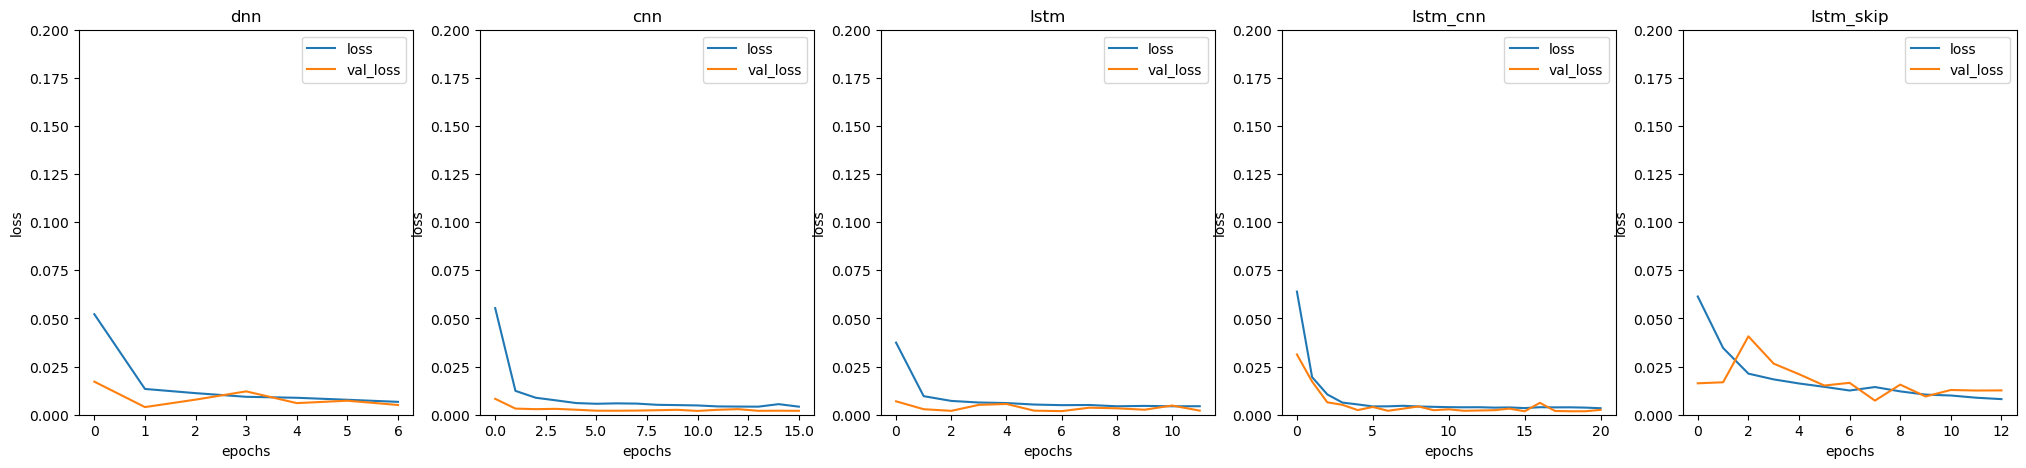

In [27]:
legend = list()

fig, axs = plt.subplots(1, 5, figsize=(25,5))

def plot_graphs(metric, val, ax, upper):
    ax.plot(val['history'].history[metric])
    ax.plot(val['history'].history[f'val_{metric}'])
    ax.set_title(key)
    ax.legend([metric, f"val_{metric}"])
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.set_ylim([0, upper])
    
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('loss', val, ax, 0.2)
print("Loss Curves")

MAE Curves


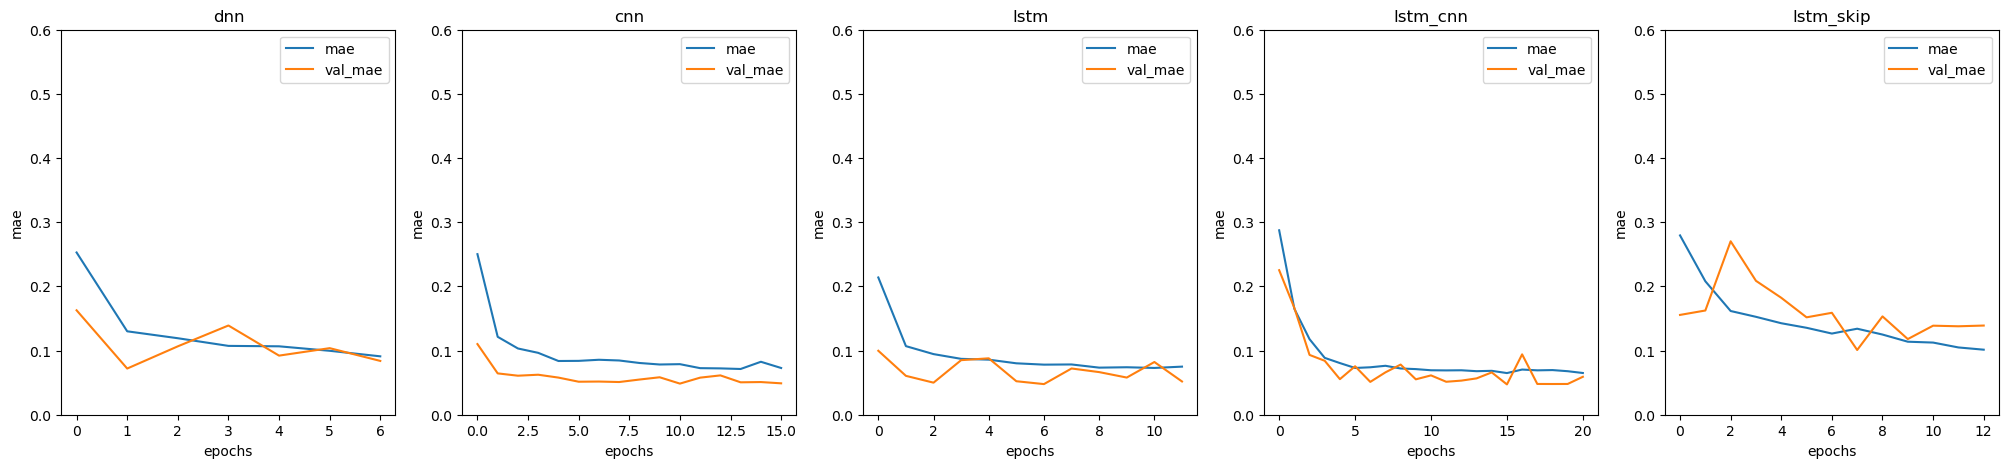

In [28]:
print("MAE Curves")
fig, axs = plt.subplots(1, 5, figsize=(25,5))
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('mae', val, ax, 0.6)